# ManyDepth
https://github.com/nianticlabs/manydepth

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import pyplot as plt

import torch
from torchvision import transforms

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from manydepth import networks
from layers import transformation_from_parameters

import open3d as o3d
import cv2

### Utility Functions

In [2]:
def load_and_preprocess_image(image_path, resize_width, resize_height):
    image = pil.open(image_path).convert('RGB')
    original_width, original_height = image.size
    image = image.resize((resize_width, resize_height), pil.LANCZOS)
    image = transforms.ToTensor()(image).unsqueeze(0)
    if torch.cuda.is_available():
        return image.cuda(), (original_height, original_width)
    return image, (original_height, original_width)

In [3]:
def load_and_preprocess_intrinsics(intrinsics_path, resize_width, resize_height):
    K = np.eye(4)
    with open(intrinsics_path, 'r') as f:
        K[:3, :3] = np.array(json.load(f))

    # Convert normalised intrinsics to 1/4 size unnormalised intrinsics.
    # (The cost volume construction expects the intrinsics corresponding to 1/4 size images)
    K[0, :] *= resize_width // 4
    K[1, :] *= resize_height // 4

    invK = torch.Tensor(np.linalg.pinv(K)).unsqueeze(0)
    K = torch.Tensor(K).unsqueeze(0)

    if torch.cuda.is_available():
        return K.cuda(), invK.cuda()
    return K, invK

### Configuration

In [4]:
target_image_path = '../assets/test_sequence_target.jpg'
source_image_path = '../assets/test_sequence_source.jpg'

model_path = '../models/CityScapes_MR'
intrinsics_json_path = '../assets/test_sequence_intrinsics.json'

mode = 'multi' # mono/multi

### Loading pretrained Model

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("-> Loading model from ", model_path)

print("   Loading pretrained encoder")
encoder_dict = torch.load(os.path.join(model_path, "encoder.pth"), map_location=device)
encoder = networks.ResnetEncoderMatching(18, False,
                                         input_width=encoder_dict['width'],
                                         input_height=encoder_dict['height'],
                                         adaptive_bins=True,
                                         min_depth_bin=encoder_dict['min_depth_bin'],
                                         max_depth_bin=encoder_dict['max_depth_bin'],
                                         depth_binning='linear',
                                         num_depth_bins=96)

filtered_dict_enc = {k: v for k, v in encoder_dict.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

print("   Loading pretrained decoder")
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict = torch.load(os.path.join(model_path, "depth.pth"), map_location=device)
depth_decoder.load_state_dict(loaded_dict)

print("   Loading pose network")
pose_enc_dict = torch.load(os.path.join(model_path, "pose_encoder.pth"),
                           map_location=device)
pose_dec_dict = torch.load(os.path.join(model_path, "pose.pth"), map_location=device)

pose_enc = networks.ResnetEncoder(18, False, num_input_images=2)
pose_dec = networks.PoseDecoder(pose_enc.num_ch_enc, num_input_features=1,
                                num_frames_to_predict_for=2)

pose_enc.load_state_dict(pose_enc_dict, strict=True)
pose_dec.load_state_dict(pose_dec_dict, strict=True)

# Setting states of networks
encoder.eval()
depth_decoder.eval()
pose_enc.eval()
pose_dec.eval()
if torch.cuda.is_available():
    encoder.cuda()
    depth_decoder.cuda()
    pose_enc.cuda()
    pose_dec.cuda()

-> Loading model from  ../models/city_scapes
   Loading pretrained encoder
   Loading pretrained decoder
   Loading pose network


### Load input data

In [6]:
# Load input data
input_image, original_size = load_and_preprocess_image(target_image_path,
                                                    resize_width=encoder_dict['width'],
                                                    resize_height=encoder_dict['height'])

source_image, _ = load_and_preprocess_image(source_image_path,
                                            resize_width=encoder_dict['width'],
                                            resize_height=encoder_dict['height'])

K, invK = load_and_preprocess_intrinsics(intrinsics_json_path,
                                        resize_width=encoder_dict['width'],
                                        resize_height=encoder_dict['height'])

### Inference

In [7]:
with torch.no_grad():

    # Estimate poses
    pose_inputs = [source_image, input_image]
    pose_inputs = [pose_enc(torch.cat(pose_inputs, 1))]
    axisangle, translation = pose_dec(pose_inputs)
    pose = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=True)

    if mode == 'mono':
        pose *= 0  # zero poses are a signal to the encoder not to construct a cost volume
        source_image *= 0

    # Estimate depth
    output, lowest_cost, _ = encoder(current_image=input_image,
                                    lookup_images=source_image.unsqueeze(1),
                                    poses=pose.unsqueeze(1),
                                    K=K,
                                    invK=invK,
                                    min_depth_bin=encoder_dict['min_depth_bin'],
                                    max_depth_bin=encoder_dict['max_depth_bin'])

    output = depth_decoder(output)

    depth = output[("disp", 0)]
    depth = depth.cpu().numpy()[:, 0][0]
    
    #sigmoid_output_resized = torch.nn.functional.interpolate(sigmoid_output, original_size, mode="bilinear", align_corners=False)
    #sigmoid_output_resized = sigmoid_output_resized.cpu().numpy()[:, 0]

/Users/mymac/miniconda3/envs/sandbox2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Analyse images

DEPTH MAP
shape:	 (192, 512)
dtype:	 float32
min:	 0.03524115
max:	 0.6337324


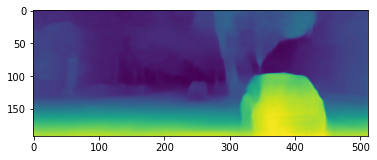


RGB IMAGE
shape:	 (192, 512, 3)
dtype:	 float32
min:	 0.0
max:	 1.0


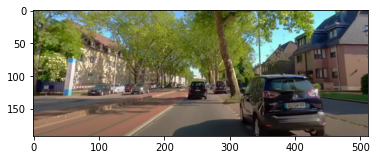

In [8]:
#depth = depth[0]

img = input_image.numpy()[0,...]
img = np.moveaxis(img, 0, -1)

print('DEPTH MAP')
print('shape:\t', depth.shape)
print('dtype:\t', depth.dtype)
print('min:\t', np.amin(depth))
print('max:\t', np.amax(depth))
plt.imshow(depth)
plt.show()

print('\nRGB IMAGE')
print('shape:\t', img.shape)
print('dtype:\t', img.dtype)
print('min:\t', np.amin(img))
print('max:\t', np.amax(img))
plt.imshow(img)
plt.show()

In [42]:
dep = (np.ones_like(depth) - depth) * 30000
dep = dep.astype(np.uint16)
print('dtype:\t', dep.dtype)
print('min:\t', np.amin(dep))
print('max:\t', np.amax(dep))

dtype:	 uint16
min:	 10988
max:	 28942


d_min = 2
d_max = 3

for y in range(dep.shape[0]):
    for x in range(dep.shape[1]):
        px = dep[y,x]
        if px < d_min or px > d_max:
            dep[y,x] = 0.0

dep = dep / 80
print('min:\t', np.amin(dep))
print('max:\t', np.amax(dep))
plt.imshow(dep)
plt.show()

### Create pointcloud

In [43]:
# transform depth and img to open3d-type-images
depth_o3d = o3d.geometry.Image(dep)
img_o3d = o3d.geometry.Image(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

In [44]:
# create RGBD image
rgbd_image = o3d.geometry.create_rgbd_image_from_color_and_depth(img_o3d, depth_o3d)

In [45]:
# create pointcloud from tgbd image
pcd = o3d.geometry.create_point_cloud_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

In [46]:
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

geometry::PointCloud with 0 points.

In [41]:
o3d.visualization.draw_geometries([pcd])